In [26]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from torch.autograd import Variable
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split  
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [27]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path)

        self.x = df.iloc[:, 12:17].values
        #self.x = np.reshape(x, (x.shape[0], 1, x.shape[1]))

        self.y = df.iloc[:, 7:8].values
        
        self.length = len(df)

    #getitem이거 왜씀?
    def __getitem__(self, index):
        # x = torch.FloatTensor([self.x[index]])
        # y = torch.FloatTensor([self.y[index]])
        # return x, y
        feature = torch.FloatTensor([self.x[index]])
        label = torch.FloatTensor(self.y[index])

        return feature, label

    def __len__(self):
        return self.length

In [28]:
dataset = CustomDataset("180801_RFB_510cy_006_DC.csv")
print(dataset.x.shape)
print(dataset.x.dtype)
print(dataset.y.shape)
print(dataset.y.dtype)

(262407, 5)
float64
(262407, 1)
float64


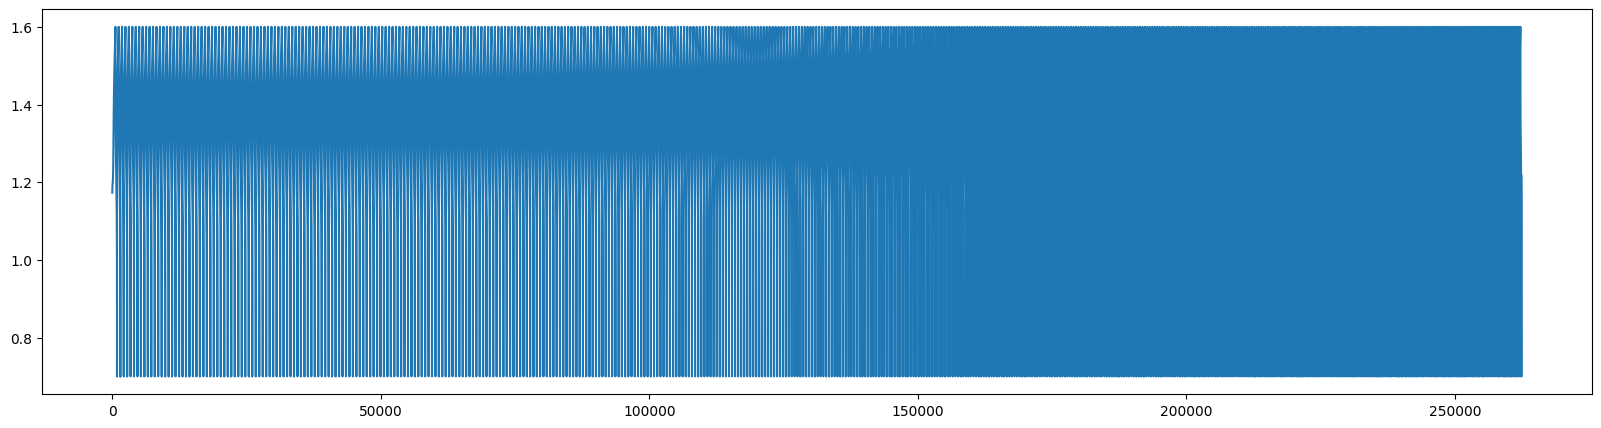

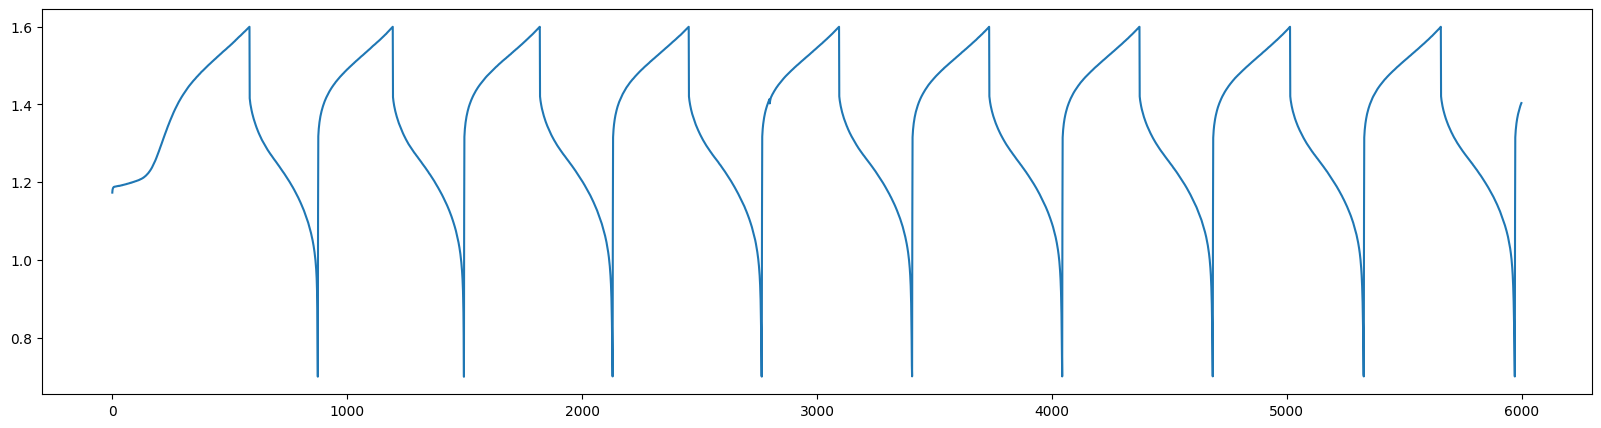

In [29]:
plt.figure(figsize=(20,5))
plt.plot(dataset.y)

plt.figure(figsize=(20,5))
plt.plot(dataset.y[:6000])
plt.show()

In [30]:
# X_train = X[:200000]
# X_test = X[200000:]

# y_train = y[:200000]
# y_test = y[200000:] 

# print(X_train.dtypes)
# print("Training Shape", X_train.shape, y_train.shape)
# print("Testing Shape", X_test.shape, y_test.shape) 

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

# X_train = X[:train_size]
# X_val = X[train_size:(train_size + validation_size)]
# X_test = X[(train_size + validation_size):(train_size + validation_size +test_size)]



print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 209925
Validation Data Size : 26240
Testing Data Size : 26242


In [31]:
train_dataloader = DataLoader(train_dataset, batch_size=250, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, drop_last=True)

In [32]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # div_term = torch.exp(
        #     torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        # )
        div_term = 1 / (10000 ** ((2 * np.arange(d_model)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[0::2])
        pe[:, 1::2] = torch.cos(position * div_term[1::2])

        pe = pe.unsqueeze(0).transpose(0, 1) # [5000, 1, d_model],so need seq-len <= 5000
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        # print(self.pe[:x.size(0), :].repeat(1,x.shape[1],1).shape ,'---',x.shape)
        # dimension 1 maybe inequal batchsize
        return x + self.pe[:x.size(0), :].repeat(1,x.shape[1],1)

In [33]:
class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        self.input_embedding  = nn.Linear(5,feature_size)
        self.src_mask = None

        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        # src with shape (input_window, batch_len, 1)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.input_embedding(src) # linear transformation before positional embedding
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [34]:
num_epochs = 50
learning_rate = 0.01

# input_size = 5 
# hidden_size = 32
feature_size = 250
num_layers = 1
dropout = 0.1

# num_classes = 1

model = TransAm(feature_size, num_layers, dropout)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
writer = SummaryWriter()

def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0], data[1]
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [36]:
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0], data[1]
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [37]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [38]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(num_epochs):
    #print(f"Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    writer.add_scalar("Loss/train", train_epoch_loss, epoch)
    val_epoch_loss, val_epoch_accuracy = validate(
        model, validation_dataloader, validation_dataset, criterion
    )
    writer.add_scalar("Loss/val", val_epoch_loss, epoch)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if epoch % 5 == 0:
        print("Train Loss: %e, Train Acc: %.2f" %(train_epoch_loss, train_epoch_accuracy))
        print('Val Loss: %e, Val Acc: %.2f' %(val_epoch_loss, val_epoch_accuracy))
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

writer.flush()
writer.close()

Training


  0%|          | 0/839 [00:00<?, ?it/s]c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([250, 1])) that is different to the input size (torch.Size([250, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 839/839 [00:31<00:00, 26.52it/s]


Validating


  0%|          | 0/1640 [00:00<?, ?it/s]c:\Users\USER\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 1640/1640 [00:01<00:00, 933.43it/s]


Train Loss: 2.389633e-01, Train Acc: 0.00
Val Loss: 3.712272e-02, Val Acc: 0.00
Training


100%|██████████| 839/839 [00:35<00:00, 23.86it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 943.40it/s]


Training


100%|██████████| 839/839 [00:35<00:00, 23.50it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 925.34it/s]


Training


100%|██████████| 839/839 [00:35<00:00, 23.81it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 921.49it/s]


Training


100%|██████████| 839/839 [00:35<00:00, 23.96it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 940.48it/s]


Training


100%|██████████| 839/839 [00:35<00:00, 23.87it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 943.80it/s]


Train Loss: 2.931824e-02, Train Acc: 0.00
Val Loss: 4.196807e-02, Val Acc: 0.00
Training


100%|██████████| 839/839 [00:35<00:00, 23.69it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 873.85it/s]


Training


100%|██████████| 839/839 [00:34<00:00, 24.09it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 946.20it/s]


Training


100%|██████████| 839/839 [00:33<00:00, 24.83it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 955.69it/s]


Training


100%|██████████| 839/839 [00:33<00:00, 24.83it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 943.31it/s]


Training


100%|██████████| 839/839 [00:33<00:00, 24.92it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 919.77it/s]


Train Loss: 2.802444e-02, Train Acc: 0.00
Val Loss: 2.962733e-02, Val Acc: 0.00
Training


100%|██████████| 839/839 [00:33<00:00, 24.84it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 927.91it/s]


Training


100%|██████████| 839/839 [00:34<00:00, 24.61it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 950.00it/s]


Training


100%|██████████| 839/839 [00:34<00:00, 24.34it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 930.21it/s]


Training


100%|██████████| 839/839 [00:34<00:00, 24.28it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 955.80it/s]


Training


100%|██████████| 839/839 [00:34<00:00, 24.33it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 938.66it/s]


Train Loss: 2.743507e-02, Train Acc: 0.00
Val Loss: 2.758375e-02, Val Acc: 0.00
Training


100%|██████████| 839/839 [00:34<00:00, 24.05it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 922.71it/s]


Training


100%|██████████| 839/839 [00:34<00:00, 24.12it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 952.94it/s]


Training


100%|██████████| 839/839 [00:35<00:00, 23.66it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 959.13it/s]


Training


100%|██████████| 839/839 [00:35<00:00, 23.66it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 932.84it/s]


Training


100%|██████████| 839/839 [00:35<00:00, 23.42it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 964.56it/s]


Train Loss: 2.744871e-02, Train Acc: 0.00
Val Loss: 2.759272e-02, Val Acc: 0.00
Training


100%|██████████| 839/839 [00:35<00:00, 23.41it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 949.41it/s]


Training


100%|██████████| 839/839 [00:34<00:00, 24.08it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 927.23it/s]


Training


100%|██████████| 839/839 [00:35<00:00, 23.47it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 899.12it/s]


Training


100%|██████████| 839/839 [00:35<00:00, 23.31it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 881.25it/s]


Training


100%|██████████| 839/839 [00:35<00:00, 23.89it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 882.27it/s]


Train Loss: 2.747730e-02, Train Acc: 0.00
Val Loss: 2.758462e-02, Val Acc: 0.00
Training


100%|██████████| 839/839 [00:35<00:00, 23.79it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 868.64it/s]


Training


100%|██████████| 839/839 [00:39<00:00, 21.45it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 875.13it/s]


Training


100%|██████████| 839/839 [00:41<00:00, 20.41it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 862.92it/s]


Training


100%|██████████| 839/839 [00:40<00:00, 20.65it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 867.49it/s]


Training


100%|██████████| 839/839 [00:39<00:00, 20.98it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 926.55it/s]


Train Loss: 2.740352e-02, Train Acc: 0.00
Val Loss: 2.759388e-02, Val Acc: 0.00
Training


100%|██████████| 839/839 [00:44<00:00, 18.95it/s]


Validating


100%|██████████| 1640/1640 [00:02<00:00, 688.46it/s]


Training


100%|██████████| 839/839 [00:46<00:00, 18.03it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 909.09it/s]


Training


100%|██████████| 839/839 [00:46<00:00, 18.18it/s]


Validating


100%|██████████| 1640/1640 [00:02<00:00, 751.25it/s]


Training


100%|██████████| 839/839 [00:48<00:00, 17.41it/s]


Validating


100%|██████████| 1640/1640 [00:02<00:00, 690.53it/s]


Training


100%|██████████| 839/839 [00:48<00:00, 17.33it/s]


Validating


100%|██████████| 1640/1640 [00:02<00:00, 639.38it/s]


Train Loss: 2.745955e-02, Train Acc: 0.00
Val Loss: 2.776086e-02, Val Acc: 0.00
Training


100%|██████████| 839/839 [00:43<00:00, 19.37it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 886.96it/s]


Training


100%|██████████| 839/839 [00:42<00:00, 19.80it/s]


Validating


100%|██████████| 1640/1640 [00:01<00:00, 961.82it/s]


Training


 85%|████████▍ | 713/839 [00:36<00:06, 19.74it/s]


KeyboardInterrupt: 

In [ ]:
df_x_ss = dataset.x
df_y_ms = dataset.y

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy() 
label_y = df_y_ms.data.numpy()


plt.figure(figsize=(10,6)) 
plt.axvline(x=dataset_size-test_size, c='r', linestyle='--') 

plt.plot(label_y, label='Actual Data') 
plt.plot(predicted, label='Predicted Data') 
plt.xlim([230000, 240000])
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 275429734596 bytes.

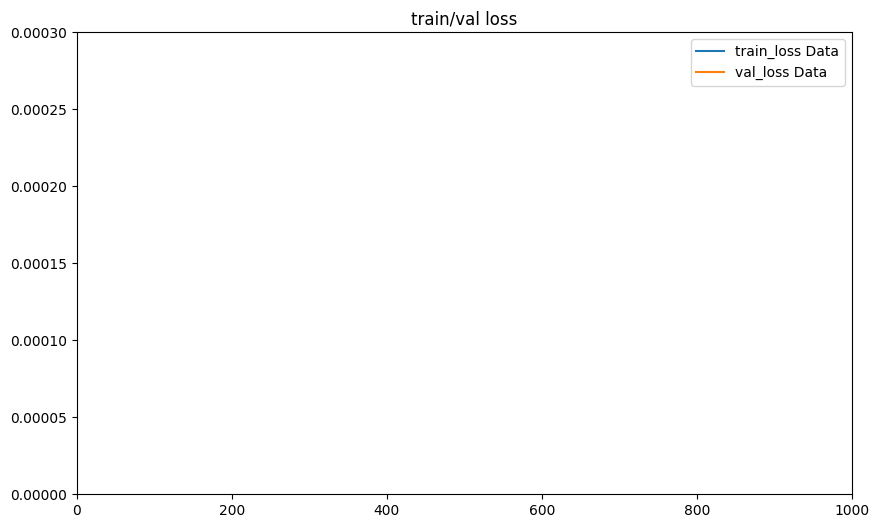

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(train_loss, label='train_loss Data') 
plt.plot(val_loss, label='val_loss Data') 
plt.title('train/val loss')
plt.xlim([0, 1000])
plt.ylim([0, 0.0003])
plt.legend()
plt.show()
